In [ ]:
# !pip install qiskit

In [ ]:
# !pip install qiskit-finance

In [ ]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [ ]:
%matplotlib inline

In [ ]:
# set number of assets (= number of qubits)

seed = 123

assets = ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE", "V", "MMM", "AXP", "CAT", "CVX", "CSCO", "PG", "JNJ" ]


# Using data from yahoo finance
# use the name listed for particular company that you wish to add

data = YahooDataProvider(
        tickers= assets , 
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2015, 12, 31),
    )

num_assets = len(assets)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
rho = data.get_similarity_matrix()
# print(rho)


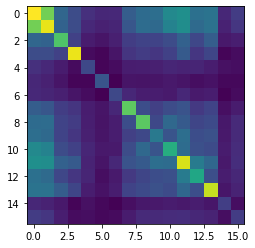

In [ ]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [ ]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term


portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00014417207292470515*x_0^2 + 0.00023453211391046..., 16 variables, 1 constraints, 'Portfolio optimization'>

In [ ]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result( result, fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    # eigenstate = result.min_eigen_solver_result.eigenstate
    # eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    # probabilities = np.abs(eigenvector) ** 2 
    # i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    # print("selection\tvalue\t\tprobability")
    # print("---------------------------------------------------")
    # for i in i_sorted:
    #     x = index_to_selection(i, num_assets)
    #     value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
    #     # value = portfolio.to_quadratic_program().objective.evaluate(x)
    #     probability = probabilities[i]
    #     row = [x, value, probability]
    #     writer.writerow(row)
    #     # print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()


In [ ]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = 'nes1.csv' #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.], value -0.0036

----------------- Full result ---------------------


In [ ]:
# !pip install qiskit-aer

In [ ]:
# VQE solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)


# initialize VQE using CVaR
# cvar_exp = CVaRExpectation(0.1, PauliExpectation())
# vqe = VQE(
#     expectation=cvar_exp,
#     optimizer=optimizer,
#     ansatz=ansatz,
#     quantum_instance=backend,
#     # callback=store_intermediate_result,
# )

#[0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.] --numpy exact solver

Optimal: selection [0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0.], value -0.0028

----------------- Full result ---------------------


In [13]:
%%time 
# VQE solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = SPSA()
cobyla.set_options(maxiter=3000)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)
# print(result)

#[0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.] --numpy exact solver

Optimal: selection [0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.], value -0.0033

----------------- Full result ---------------------
CPU times: user 25min 48s, sys: 5.25 s, total: 25min 53s
Wall time: 25min 34s


### as you can see here with 8 assets, with vqe n cobyla our results are not so good or no near to MPT seleccted assets. 
### but VQE n SPSA, same results as numpy_exact_solver and MPT are getting produces. 


In [14]:
%%time 
# QAOA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [0. 0. 1. 1. 0. 1.] -numpy exact solver

Optimal: selection [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.], value -0.0033

----------------- Full result ---------------------
CPU times: user 18min 49s, sys: 4 s, total: 18min 53s
Wall time: 18min 51s


In [80]:
# %%time 
# # QAOA solution
# #provide fname ='complete address/location of your .csv file'

# algorithm_globals.random_seed = 1234
# backend = Aer.get_backend("qasm_simulator")

# cobyla = SPSA()
# cobyla.set_options(maxiter=250)
# quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
# qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
# qaoa = MinimumEigenOptimizer(qaoa_mes)
# result = qaoa.solve(qp)

# fname = 'qaoa1.csv' #change the location and name of .csv file
# print_result(result, fname)

# # [0. 0. 1. 1. 0. 1.] -numpy exact solver

#### weight allocation part after asset selection using quantum

In [64]:
# selected_assets = [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]

selected_assets = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
assets = ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE", "V", "MMM", "AXP", "CAT", "CVX", "CSCO", "PG", "JNJ" ]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['MSFT', 'AAPL', 'KO', 'WMT', 'MCD', 'NKE', 'V', 'MMM']


In [65]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-1-1', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()

[*********************100%***********************]  8 of 8 completed


,AAPL,KO,MCD,MMM,MSFT,NKE,V,WMT
Date,,,,,,,,
2011-01-03,10.049907,22.830099,55.079609,62.327366,21.917925,18.765163,16.221111,41.665161
2011-01-04,10.102357,22.357538,53.432991,62.241196,22.004093,18.303070,16.239511,41.825508
2011-01-05,10.184993,22.224524,53.684669,62.241196,21.933594,18.422945,16.582243,41.550606
2011-01-06,10.176762,22.063494,53.361069,61.860577,22.575933,18.257296,16.830664,41.206951
2011-01-07,10.249641,22.024988,53.476116,61.925198,22.403599,18.207157,16.782368,41.298592


In [66]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,AAPL,KO,MCD,MMM,MSFT,NKE,V,WMT
Date,,,,,,,,
2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,0.005205,-0.020916,-0.030351,-0.001383,0.003924,-0.024933,0.001134,0.003841
2011-01-05,0.008147,-0.005967,0.004699,0.000000,-0.003209,0.006528,0.020885,-0.006594
2011-01-06,-0.000808,-0.007272,-0.006046,-0.006134,0.028865,-0.009032,0.014870,-0.008305
2011-01-07,0.007136,-0.001747,0.002154,0.001044,-0.007663,-0.002750,-0.002874,0.002221


In [67]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.17770724 0.07819307 0.19654165 0.18063517 0.11693401 0.19705185
 0.01782405 0.03511295]


In [68]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [69]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [70]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [71]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.2, 0.1, 0.1, 0.1, 0.2, 0.1,0.1, 0.1 ]
# tuple((0, 1) for stocks in range(len(my_assets)))

In [72]:
neg_sharpe(weights)

-1.0928564860739265

In [73]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -1.3949456337947808
     jac: array([-1.15071237e-03,  1.03488669e-01, -2.91094184e-04,  1.42955616e-01,
       -2.49415636e-04,  6.56545162e-05,  2.24560499e-04,  2.31322005e-01])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([7.87421864e-02, 0.00000000e+00, 1.29401214e-01, 2.16840434e-19,
       3.06534834e-02, 2.20195412e-01, 5.41007704e-01, 9.08561421e-17])

In [74]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [75]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [76]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'MSFT': 0.07874218644638858,
 'AAPL': 0.0,
 'KO': 0.1294012141299027,
 'WMT': 2.168404344971009e-19,
 'MCD': 0.030653483393033924,
 'NKE': 0.22019541174110746,
 'V': 0.5410077042895673,
 'MMM': 9.085614205428527e-17}

In [77]:
my_assets

['MSFT', 'AAPL', 'KO', 'WMT', 'MCD', 'NKE', 'V', 'MMM']

In [78]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  1.7117734920500771


In [79]:
risk_ret_dict_of_quantum

{'returns': 25.157319369337642,
 'risk': 14.696640347671467,
 'sharpe_ratio': 1.7117734920500771}

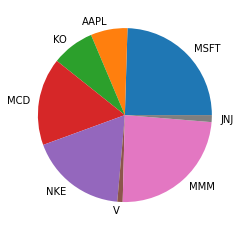

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [43]:
# 4_stocks= ["JPM", "GS", "MSFT", "WMT"]
# 6_stocks= ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]
# 8_stocks= ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE"]
# 10_stocks=["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "DIS", "BA", "MCD", "NKE"]

## MPT CODE to benchmark 

In [44]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [45]:
NUM_TRADING_DAYS = 252 #252*5 cosnidered previously, now I'm just taing for 1 year
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE", "V", "MMM", "AXP", "CAT", "CVX", "CSCO", "PG", "JNJ" ]

In [46]:
# start_date = '2011-01-01' # YY/MM/DD
# end_date = '2015-12-31'   # YY/MM/DD

In [47]:
## this is previously defined download_data function, Which need to change, as dataset values of this funtion and Weight allocation part were not same. even after dates were same.

# def download_data():
#     stock_data = {}
#     for stock in stocks:
#         ticker = yf.Ticker(stock)
#         stock_data[stock] = ticker.download(start=start_date, end=end_date )['Close']
#     df = pd.DataFrame(stock_data)
#     df.head()
#     return pd.DataFrame(stock_data)

In [48]:
def download_data():
    stocks_data = yf.download(stocks, start = '2011-1-1', end = '2015-12-31')['Adj Close']
    # stocks_data.head()
    return pd.DataFrame(stocks_data)

In [49]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [50]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [51]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [52]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [53]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [54]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [55]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [56]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [57]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [58]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)


In [59]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))


In [60]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

[*********************100%***********************]  16 of 16 completed


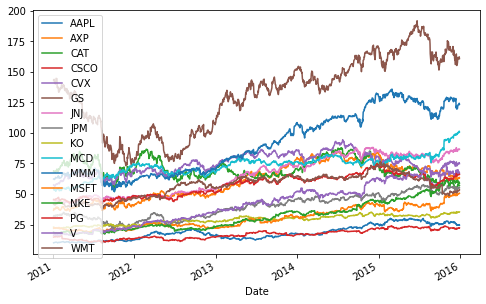

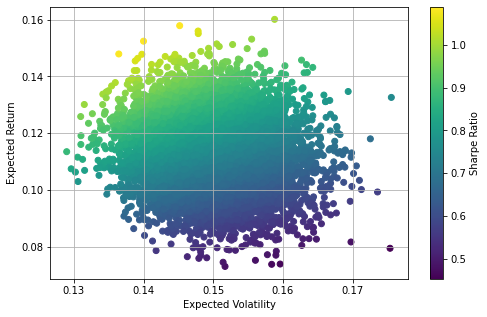

Optimal Portfolio:  [0.07  0.    0.    0.    0.    0.    0.166 0.    0.    0.079 0.    0.013
 0.195 0.    0.477 0.   ]
Expected return, volatility and sharpe ratio:  [0.23748975 0.16921245 1.40350042]


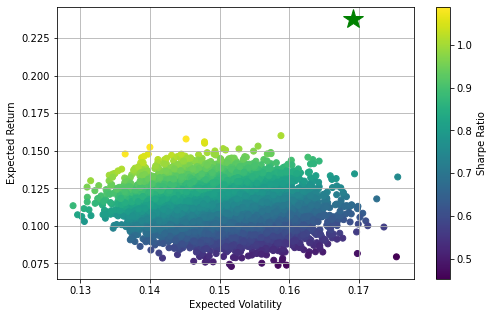

In [61]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

## this cell has too much importance, cause I have been using this cell to verify that 2 datsets which I'm getting are coreect or not. 
## finally after changing the download_data() function, it'd have fixed in proper way. 

In [62]:
#selected_stocks_data.head() 

In [63]:
risk_ret_dict_of_quantum

{'returns': 23.749755580452984,
 'risk': 14.464516450230388,
 'sharpe_ratio': 1.6419322182093892}